In [50]:
from qiskit import QuantumCircuit, IBMQ, transpile
from qiskit.providers.aer import AerSimulator
from qiskit.tools.visualization import plot_histogram
import qiskit.tools.jupyter
from qiskit.visualization import plot_histogram, plot_gate_map, plot_circuit_layout
from qiskit.tools.monitor import job_monitor
#%qiskit_version_table
#%qiskit_copyright
import numpy as np
from time import gmtime, strftime, localtime
import matplotlib.pyplot as plt
import itertools
import matplotlib.cm as cm  
%matplotlib inline

from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

service = QiskitRuntimeService(channel="****", token="****", instance="****")

# Mapping the old layout to the qubits of the IBM machine

g0=0
g1=1
g2=2
g3=3
g4=4
g5=5
g6=6
g7=7
g8=8
g9=9
g10=10
g11=11
g12=12
#g13=13
g14=13
#g15=15
g16=14
g17=15
g18=16
g19=17

#g20=2
#g21=21
#g22=22
#g23=23
#g24=24
#g25=25
#g26=26

G=[g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g14,g16,g17,g18,g19]

# Set the measurement you want to either 'charge' or 'flux' or 'both'.
measurement_type = 'both'

# Set the initial state to 'identity', 'ground state' or 'random'

initial_state = 'ground state'

# Set whether or not a ribbon is applied (True/False)

ribbon = True

# Initialize Qubits
circ = QuantumCircuit(18, 18)


if initial_state == 'ground state':
# Prepare groundstate

    circ.h(g0)
    circ.h(g1)
    circ.h(g2)
    circ.h(g9)
    circ.h(g10)
    circ.h(g11)


    circ.cx(g0,g3)
    circ.cx(g1,g4)
    circ.cx(g2,g5)
    circ.cx(g9,g6)
    circ.cx(g10,g7)
    circ.cx(g11,g8)

    
if ribbon:
  ## Ribbon 1 up to the 'crossover swap'
    print('test')
    circ.h(g16)                        # create Bell pair
    circ.cx(g16,g17)
    #circ.swap(g0,g1)                   # Swap qubits representing R2 and m on edge 1
    circ.cx(g0,g17)                    # Conjugate ancilla
    circ.cx(g2,g0)                     # Start the multiplication onto the edge
    circ.cx(g1,g0)                     # Swap back and CNOT m onto R2, 4 CNOTs simplify to 2
    #circ.cx(g0,g1)
    circ.cx(g17,g1)                    # CNOT from ancilla and complete the multiplication onto edge 1
    circ.x(g2)

    #circ.swap(g17,g20)                 # Move ancilla to edge 4, swap R2 and R on edge 4
    #circ.swap(g17,g21)
    #circ.swap(g7,g8)

    circ.cx(g17,g7)                    # CNOT from ancilla onto edge 4
    #circ.swap(g7,g8)
    circ.cx(g8,g7)
    circ.x(g7)                         # The two X gates complete the postmultiplication of edge 4 by the ancilla inverse
    circ.x(g8)
    
    
## Ribbon 2 up to the 'crossover swap'
    circ.h(g18)                         # create Bell pair
    circ.cx(g18,g19)                      
    #circ.swap(g9,g6)                    # SWAPs for conjugation by edge 6
    circ.cx(g9,g19)                     # conjugation
    #circ.swap(g9,g6)

    
     # The crossover circ.swap

    #circ.swap(g17,g19)                     # circ.swaps the position of the two ribbon ancillas

      # Completing ribbon 1
    circ.cx(g6,g17)                      # circ.cx from edge four, the m qubit, onto the ancilla for conjugation


      # Completing ribbon 2
    #circ.swap(g19,g22)
    circ.cx(g8,g7)
    circ.cx(g19,g7)
    circ.x(g8)

                     

      # Moving both ancilla pairs back together, undoing bell pair state and measure

    #circ.swap(g16,g20)
    #circ.swap(g22,g19)
    #circ.swap(g16,g21)
   # circ.swap(g19,g17)
    circ.cx(g16,g17)
    circ.cx(g18,g19)
    circ.h(g16)
    circ.h(g18)
    
    
        
if measurement_type == 'both':
    print('both')
    circ.h(g12)
    circ.h(g14)        # Set up superposition of subgroup {e,m,R2,mR2}. Qubit 12 encodes m, qubit 14 encodes R2.

  #  circ.cx(g12,g13)         # Multiply onto neighbouring ancillas
  #  circ.cx(g14,g15)

    circ.cx(g12,g6)          # Multiply into the edges 3 and 4 that make up a plaquette, acting on the m and R2 qubits.
    circ.cx(g12,g9)
    circ.cx(g14,g7)
    circ.cx(g14,g10)

#    circ.cx(g12,g13)         # Undo multiplication onto the additional ancillas
#    circ.cx(g14,g15)

    circ.h(g12)  ##strategy=InsertStrategy.NEW_THEN_INLINE)        # Hadamard back
    circ.h(g14)
   
    if ribbon:
        measuredbits=12             
        circ.measure(G[6:12] + [g12,g14]+G[14:18],range(measuredbits)) 
    else:
        measuredbits=8             
        circ.measure(G[6:12] + [g12,g14],range(measuredbits))
        
        

        
        
from qiskit.providers.fake_provider import FakeMumbai

        
local_layout=[15,18,21, 16,19,22, 4, 10,7, 5,11,8,3,14,13,12,0,1] 
backend = FakeMumbai()
sim = AerSimulator.from_backend(backend)


min = 100
print(strftime("%Y-%m-%d %H:%M:%S", localtime()))

# Transpile the circuit for the noisy basis gates
for i in range(10):
    ttest = transpile(circ, sim, initial_layout=local_layout,optimization_level=3)
    testmin=ttest.depth()
    if testmin< min:
        min=testmin
        tcirc=ttest
        print(min)   
print(strftime("%Y-%m-%d %H:%M:%S", localtime()))
print(tcirc.depth())


test
both
2022-09-30 16:19:41
77
58
2022-09-30 16:19:45
58


In [51]:

with Sampler(circuits=[tcirc], service=service, options={ "backend": "" }, skip_transpilation=True) as sampler:
    result = sampler(circuits=[0],shots=10000)
    print(result)


SamplerResult(quasi_dists=[{'000000000000001011': 0.0015, '000000110000110110': 0.0016, '000000011000111101': 0.0012, '000000110100110110': 0.0007, '000000101100110100': 0.0015, '000000111100110110': 0.0011, '000000011100100110': 0.0019, '000000010100100100': 0.0018, '000000110101110110': 0.0016, '000000101000101101': 0.0015, '000000000000000010': 0.0014, '000000100101101101': 0.0017, '000000001001110110': 0.0013, '000000100001110100': 0.002, '000000111100010010': 0.0022, '000000000100010000': 0.0013, '000000111101100100': 0.0018, '000000111001000000': 0.0021, '000000011100000000': 0.0018, '000000011000100100': 0.0018, '000000111100101101': 0.0015, '000000011001010010': 0.0017, '000000010001000010': 0.0018, '000000010000111111': 0.0019, '000000001101000010': 0.0015, '000000000001011011': 0.001, '000000111000110110': 0.0013, '000000010000000010': 0.0017, '000000111000101111': 0.0018, '000000010101101111': 0.0018, '000000001001001001': 0.0023, '000000111001011011': 0.0024, '0000001010000

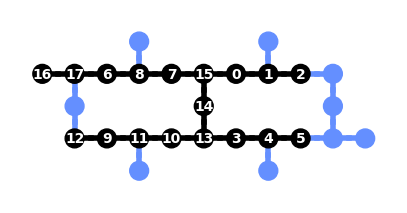

In [52]:
tcirc.depth()
plot_circuit_layout(tcirc,backend)        

In [53]:
## Define simulator for ideal simulation
#sim_ideal = AerSimulator()

## Execute and get counts
#results = sim_ideal.run(transpile(tcirc, sim_ideal),shots=5000).result()
#counts = results.get_counts(0)

In [54]:
counts = result.quasi_dists[0]
print(counts)

{'000000000000001011': 0.0015, '000000110000110110': 0.0016, '000000011000111101': 0.0012, '000000110100110110': 0.0007, '000000101100110100': 0.0015, '000000111100110110': 0.0011, '000000011100100110': 0.0019, '000000010100100100': 0.0018, '000000110101110110': 0.0016, '000000101000101101': 0.0015, '000000000000000010': 0.0014, '000000100101101101': 0.0017, '000000001001110110': 0.0013, '000000100001110100': 0.002, '000000111100010010': 0.0022, '000000000100010000': 0.0013, '000000111101100100': 0.0018, '000000111001000000': 0.0021, '000000011100000000': 0.0018, '000000011000100100': 0.0018, '000000111100101101': 0.0015, '000000011001010010': 0.0017, '000000010001000010': 0.0018, '000000010000111111': 0.0019, '000000001101000010': 0.0015, '000000000001011011': 0.001, '000000111000110110': 0.0013, '000000010000000010': 0.0017, '000000111000101111': 0.0018, '000000010101101111': 0.0018, '000000001001001001': 0.0023, '000000111001011011': 0.0024, '000000101000011011': 0.0016, '0000000101

## Group stucture and Decoder

In [55]:
R = np.array([[0, -1],[1, 0]])
M = np.array([[1, 0],[0, -1]])
G = np.zeros([2,2,8])
G[:,:,0] = np.eye(2) # The D_4 group [via it's faithful 2d rep]
G[:,:,1] = R
G[:,:,2] = R@R
G[:,:,3] = R@R@R
G[:,:,4] = M
G[:,:,5] = M@R
G[:,:,6] = M@R@R
G[:,:,7] = M@R@R@R
g_lab = ['e','r','rr','rrr','m','mr','mrr','mrrr']
order = len(g_lab)
# Binary encoding: | M, R, RR> -> 8 element encoding needs to be translated in this formalism
encode = {'000':0,'010':1, '001':2, '011':3, '100':4,'110':5, '101':6, '111':7}
# Daan's encoding m RR R .... <- also need to note the arrangement on the actual machine
encode = {'000':0,'001':1, '010':2, '011':3, '100':4,'101':5, '110':6, '111':7}

C_e = np.array([0])  # Conj Classes
C_r = np.array([1,3])
C_rr = np.array([2])
C_m = np.array([4,6])
C_mr = np.array([5,7])

Z_e = np.array([0, 1, 2, 3, 4, 5, 6, 7])  # Centers Classes
Z_r = np.array([0, 1, 2, 3])
Z_rr = np.array([0, 1, 2, 3, 4, 5, 6, 7])
Z_m = np.array([0, 2, 4, 6])
Z_mr = np.array([0, 2, 5, 7])

#### Function to query the group structure:

In [56]:
def dag(M):
    return np.conjugate(M.T)
def matInv(M):
    return np.linalg.inv(M)
def is_eq(A,B):
    return np.array_equal(A,B)

def q(c):
    Q_C = [0, 0, 0, 4, 0, 0, 3, 3] # This for q_c instead : Coset Representatives
    return Q_C[c]

def grp(x):
    return G[:,:,x] # USE G AS A GLOBAL VAR!!! ---- CAREFUL !


def grp_i(i):
    return matInv(G[:,:,i])

def index(h):
    for i in range(8): # to be generalised
        if np.array_equal(h, G[:,:,i]):
            return i

def inv(x):
    for i in range(8): # to be generalised
        if np.array_equal(matInv(G[:,:,x]), G[:,:,i]):
            return i

## Data Anal

In [63]:
full_table = np.zeros([4,8], dtype=int)
succ = 0
repetitions = 10000
for rev_key, value in counts.items():
    key = rev_key[::-1]
    #print(key)
    g_1 = encode[key[0:3]]
    g_2 = encode[key[3:6]]
    flux = index(grp(g_2)@grp_i(g_1))
    charge = int(key[6:8],2)
    ribbon = key[8:12]
    if ribbon == '0000':
        succ += repetitions*value
        full_table[charge, flux] += repetitions*value
print(succ)
print(full_table)

599.0
[[153   0 162   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [138   0 146   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]


In [64]:
results = full_table.reshape([32,1]).T[0]

In [65]:
charge_mmt_res = ['$+ +$','$- +$','$+ -$','$- -$']
charge_mmt_res_num = [0, 1, 2, 3]
g_lab_num = [0,1,2,3,4,5,6,7]
mindex_num = list(itertools.product(charge_mmt_res_num, g_lab_num))
mindex = list(itertools.product(charge_mmt_res, g_lab))

In [66]:
x = [list(t) for t in zip(*mindex_num)][0]
y = [list(t) for t in zip(*mindex_num)][1]
x_lab = [list(t) for t in zip(*mindex)][0]
y_lab = [list(t) for t in zip(*mindex)][1]
z = results
bottom = np.zeros_like(z)
width = 0.3
depth = width*2

In [67]:
a = lambda i: charge_mmt_res[i]

## Plot

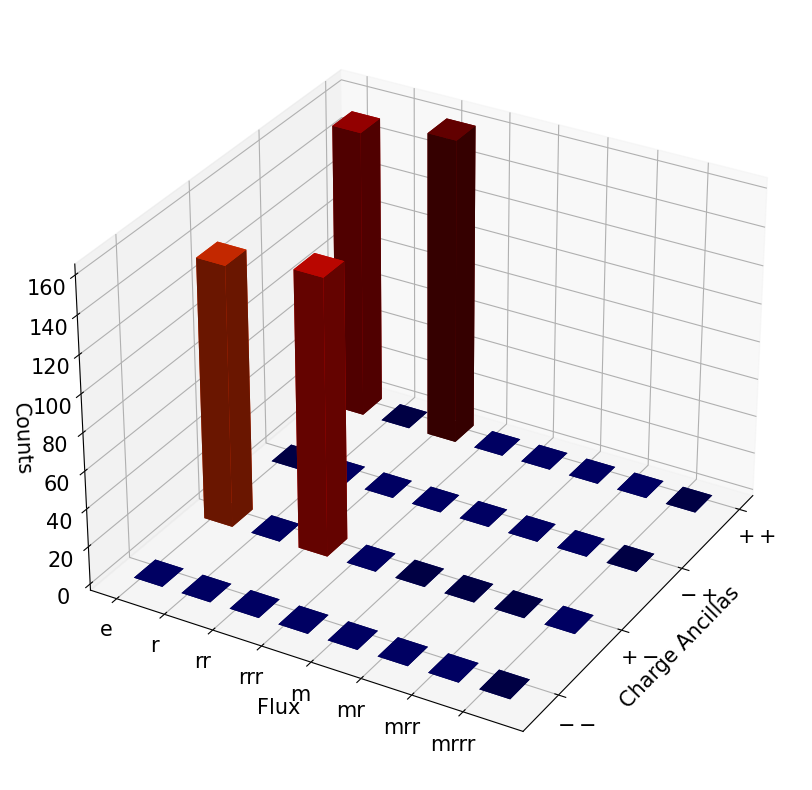

In [68]:
# setup the figure and axes
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(111, projection='3d')

plt.rc('font', size=15) 

cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
max_height = np.max(z)   # get range of colorbars so we can normalize
min_height = np.min(z)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in z]

ax1.bar3d(x, y, bottom, width, depth, z, color=rgba)
#surf = ax1.plot_surface(np.array(x).reshape(4,8), np.array(y).reshape(4,8), z.reshape(4,8), cmap=cm.coolwarm, linewidth=0, antialiased=False)

ax1.set_xlabel('Charge Ancillas')
ax1.set_ylabel('Flux')
ax1.set_zlabel('Counts')

ax1.set_xticks(charge_mmt_res_num)
ax1.set_xticklabels(charge_mmt_res)
ax1.set_yticks(g_lab_num)
ax1.set_yticklabels(g_lab)

# ax1.text(0,0-0.2,186, r'$O$', (1,0,0), size= 20)
# ax1.text(0,2-0.2,199, r'$\tilde{O}$', (1,0,0), size= 20)
# ax1.text(2,0-0.2,172, r'$\Psi_{mr}$', (1,0,0), size= 20)
# ax1.text(2,2-0.2,183, r'$\tilde{\Psi}_{mr}$', (1,0,0), size= 20)
# #ax1.text(1,0-0.15,55, r'$X$', (1,1,0), size= 20)

ax1.view_init(elev=30, azim=30)
plt.savefig('fusion_res.png', dpi=300)
plt.show()

